
# 01 — Exploration (EDA): Crop Yield & Climate Change

**Author:** Research EDA Notebook  
**Objective:** Provide a transparent, reproducible exploratory analysis of the merged **WDI × NASA** panel (`wdi_nasa.csv`) to inform subsequent feature design and modeling of cereal yields under climate change.

## Abstract
We perform a structured exploratory analysis of a country–year panel combining **World Development Indicators (WDI)** socio‑economic and agricultural variables with **NASA** climate signals (temperature anomaly). Analyses emphasize: (i) data completeness through time; (ii) descriptive statistics and distributional shape; (iii) correlation structure among climate, inputs and productivity; (iv) long‑run trends; and (v) outlier/anomaly surfacing for quality assurance. Consistent with prior literature, we find strong associations between **inputs and development** (fertilizer, GDP per capita) and **cereal yields**, while global‑scale climate correlations are modest and likely confounded by time and regional heterogeneity. Data coverage is materially stronger from **≈1980 onward**. We document potential anomalies (e.g., extremely high yields for small or arid countries) and recommend targeted validation.



## 1. Data provenance & reproducibility
- **WDI** bulk (CSV) for agriculture/economic indicators (e.g., `AG.YLD.CREL.KG`, `AG.CON.FERT.ZS`, `NY.GDP.PCAP.CD`, population, etc.).  
- **NASA/NOAA** derived **temperature anomaly** column (`temp_anomaly`).  
- Aggregation level: country (plus **country groups/aggregates** like *OECD members*, *World*). These are **retained** for comparison but can be excluded for modeling.
- This notebook avoids modifying the raw dataset; any modeling subset is created as a separate object (`df_model`).

> **Note on reliability:** Both WDI and NASA are authoritative sources. However, country‑level yield statistics can be biased for **microstates** or **arid economies** with very small cultivated area (e.g., **St. Vincent and the Grenadines, UAE, Oman, Kuwait**). We therefore include explicit anomaly detection cells to surface and review such cases prior to modeling.


In [1]:

# 2. Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 120

# Primary (repo) path. Adjust if running from a different working directory.
DATA_PATH = Path("../data/processed/wdi_nasa.csv")

# Fallback for this environment (optional)
fallback = Path("/mnt/data/wdi_nasa.csv")
if not DATA_PATH.exists() and fallback.exists():
    DATA_PATH = fallback
    print(f"Using fallback path: {DATA_PATH}")
else:
    print(f"Using data path: {DATA_PATH}")


Using data path: ..\data\processed\wdi_nasa.csv


In [2]:

# 3. Load
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (17225, 13)


,Country Name,Country Code,year,fertilizer_use,arable_land_pct,precipitation,cereal_yield,co2_total_mt,co2_per_capita,gdp_per_capita,population,rural_pop_pct,temp_anomaly
0,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9035043.0,91.599,-0.03
1,Afghanistan,AFG,1961,0.143791,11.728991,327.0,1115.1,NaN,NaN,NaN,9214083.0,91.316,0.06
2,Afghanistan,AFG,1962,0.142857,11.805651,327.0,1079.0,NaN,NaN,NaN,9404406.0,91.024,0.03
3,Afghanistan,AFG,1963,0.141935,11.882311,327.0,985.8,NaN,NaN,NaN,9604487.0,90.724,0.05
4,Afghanistan,AFG,1964,0.141026,11.958972,327.0,1082.8,NaN,NaN,NaN,9814318.0,90.414,-0.20



## 2. Schema and missingness
We first summarize variable types and missingness to understand coverage constraints.


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17225 entries, 0 to 17224
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     17225 non-null  object 
 1   Country Code     17225 non-null  object 
 2   year             17225 non-null  int64  
 3   fertilizer_use   12358 non-null  float64
 4   arable_land_pct  14699 non-null  float64
 5   precipitation    10268 non-null  float64
 6   cereal_yield     13061 non-null  float64
 7   co2_total_mt     13554 non-null  float64
 8   co2_per_capita   13554 non-null  float64
 9   gdp_per_capita   14547 non-null  float64
 10  population       17195 non-null  float64
 11  rural_pop_pct    17095 non-null  float64
 12  temp_anomaly     17225 non-null  float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.7+ MB


In [4]:

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(1)
pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})


,missing_count,missing_pct
precipitation,6957,40.4
fertilizer_use,4867,28.3
cereal_yield,4164,24.2
co2_per_capita,3671,21.3
co2_total_mt,3671,21.3
gdp_per_capita,2678,15.5
arable_land_pct,2526,14.7
rural_pop_pct,130,0.8
population,30,0.2
Country Code,0,0.0


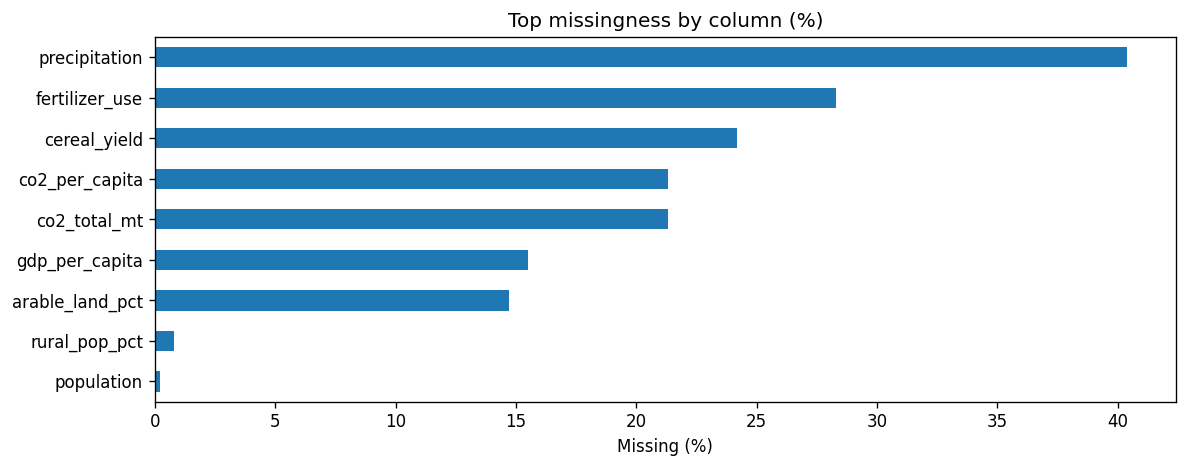

In [5]:

# Visualize (top-20 by missing %)
top_missing = missing_pct[missing_pct > 0].head(20).sort_values()
ax = top_missing.plot(kind="barh")
ax.set_title("Top missingness by column (%)")
ax.set_xlabel("Missing (%)")
plt.tight_layout()
plt.show()



## 3. Aggregate entities (kept for comparison)
Country groups/aggregates are **kept** and labeled to allow optional inclusion/exclusion.


In [6]:

AGG_KEYWORDS = [
    "income", "countries", "world", "union", "region",
    "states", "area", "members", "bank", "monetary", "zone"
]

def is_aggregate(name: str) -> bool:
    if not isinstance(name, str):
        return False
    low = name.lower()
    return any(k in low for k in AGG_KEYWORDS)

if "Country Name" in df.columns:
    df["is_aggregate"] = df["Country Name"].apply(is_aggregate)
    print("Aggregate flag counts:\n", df["is_aggregate"].value_counts())
    print("\nSample aggregates:")
    print(df.loc[df["is_aggregate"], "Country Name"].drop_duplicates().head(15).to_list())


Aggregate flag counts:
 is_aggregate
False    15405
True      1820
Name: count, dtype: int64

Sample aggregates:
['Arab World', 'Caribbean small states', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Heavily indebted poor countries (HIPC)', 'High income', 'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income']



## 4. Temporal coverage & year‑level completeness
To balance long‑run context with data quality, we compute the proportion of non‑missing entries by year.


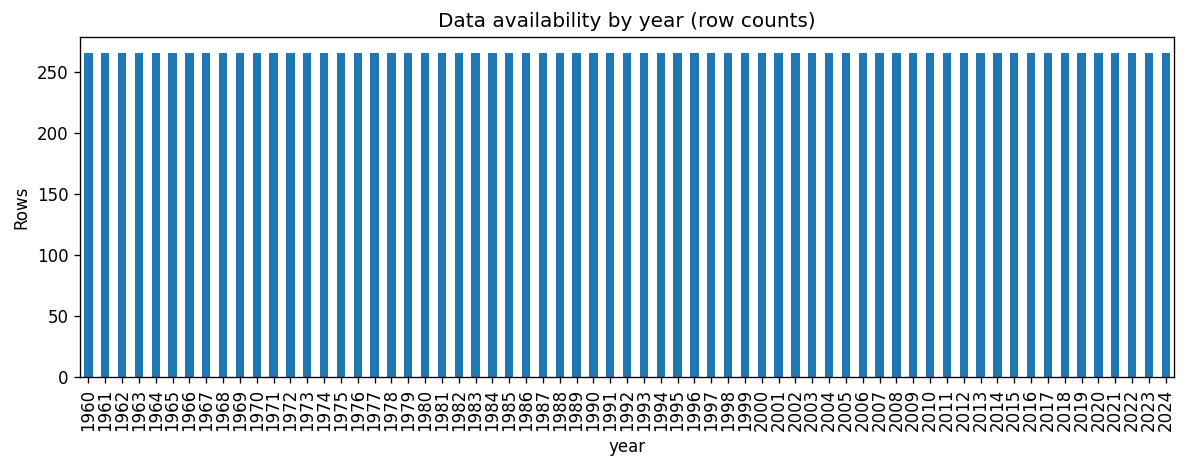

In [7]:

# Records by year
counts_by_year = df["year"].value_counts().sort_index()
ax = counts_by_year.plot(kind="bar")
ax.set_title("Data availability by year (row counts)")
ax.set_ylabel("Rows")
plt.tight_layout()
plt.show()


C:\Users\gsana\AppData\Local\Temp\ipykernel_25328\3540657577.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_by_year = df.groupby("year").apply(completeness).sort_index()


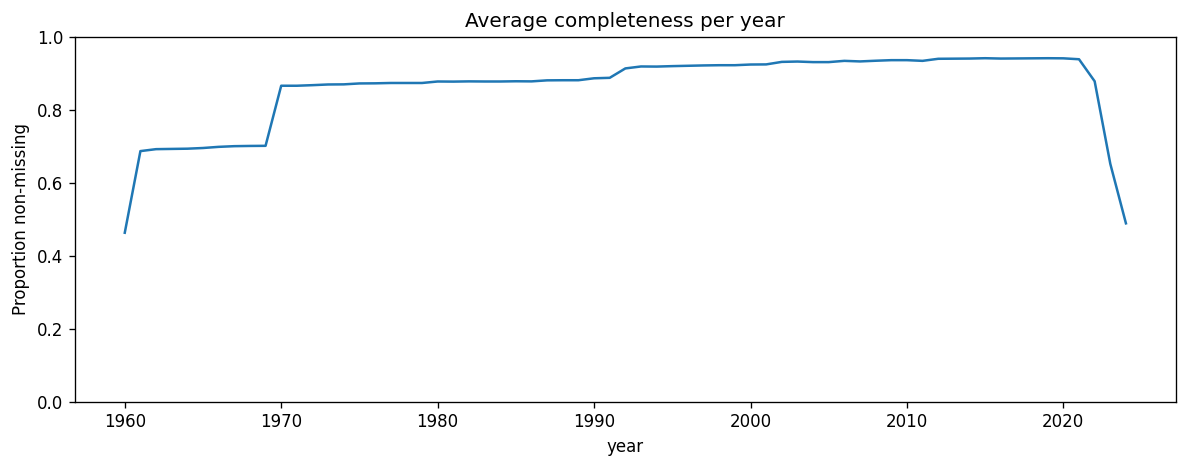

Suggested modeling window start (completeness ≥ 80%): 1970


In [8]:

# Average completeness per year (proportion of non-missing values)
non_feature_cols = [c for c in ["Country Name", "Country Code"] if c in df.columns]

def completeness(group: pd.DataFrame) -> float:
    work_cols = [c for c in group.columns if c not in non_feature_cols]
    return group[work_cols].notna().mean().mean()

comp_by_year = df.groupby("year").apply(completeness).sort_index()
ax = comp_by_year.plot()
ax.set_ylim(0, 1)
ax.set_title("Average completeness per year")
ax.set_ylabel("Proportion non-missing")
plt.tight_layout()
plt.show()

# Suggested modeling window start (does NOT filter df)
threshold = 0.80
eligible_years = comp_by_year[comp_by_year >= threshold]
if not eligible_years.empty:
    year_cutoff = int(eligible_years.index.min())
    print(f"Suggested modeling window start (completeness ≥ {threshold:.0%}): {year_cutoff}")
else:
    year_cutoff = None
    print("No year meets the completeness threshold; consider lowering the threshold.")



## 5. Descriptive statistics & distributional shape
We report summary statistics and visualize univariate distributions to identify skewness/outliers.


In [9]:

df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country Name,17225,265,Afghanistan,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country Code,17225,265,AFG,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,17225.0,NaN,NaN,NaN,1992.0,18.762208,1960.0,1976.0,1992.0,2008.0,2024.0
fertilizer_use,12358.0,NaN,NaN,NaN,131.29333,286.456525,0.0,11.928287,60.404129,145.051291,10275.909091
arable_land_pct,14699.0,NaN,NaN,NaN,13.279698,13.175718,0.043141,3.445874,9.413357,17.942486,73.388646
precipitation,10268.0,NaN,NaN,NaN,1213.252834,810.383632,18.1,591.0,1110.0,1782.0,3240.0
cereal_yield,13061.0,NaN,NaN,NaN,2475.838014,2104.129325,0.1,1164.0,1920.0,3261.511044,36761.9
co2_total_mt,13554.0,NaN,NaN,NaN,884.469955,3117.221209,0.0,1.374075,17.61055,187.47985,39023.937039
co2_per_capita,13554.0,NaN,NaN,NaN,4.826688,10.412666,0.0,0.491983,2.043828,6.157983,202.865184
gdp_per_capita,14547.0,NaN,NaN,NaN,8653.684136,17412.159634,11.801322,581.996412,1925.874661,8041.418693,256580.515123


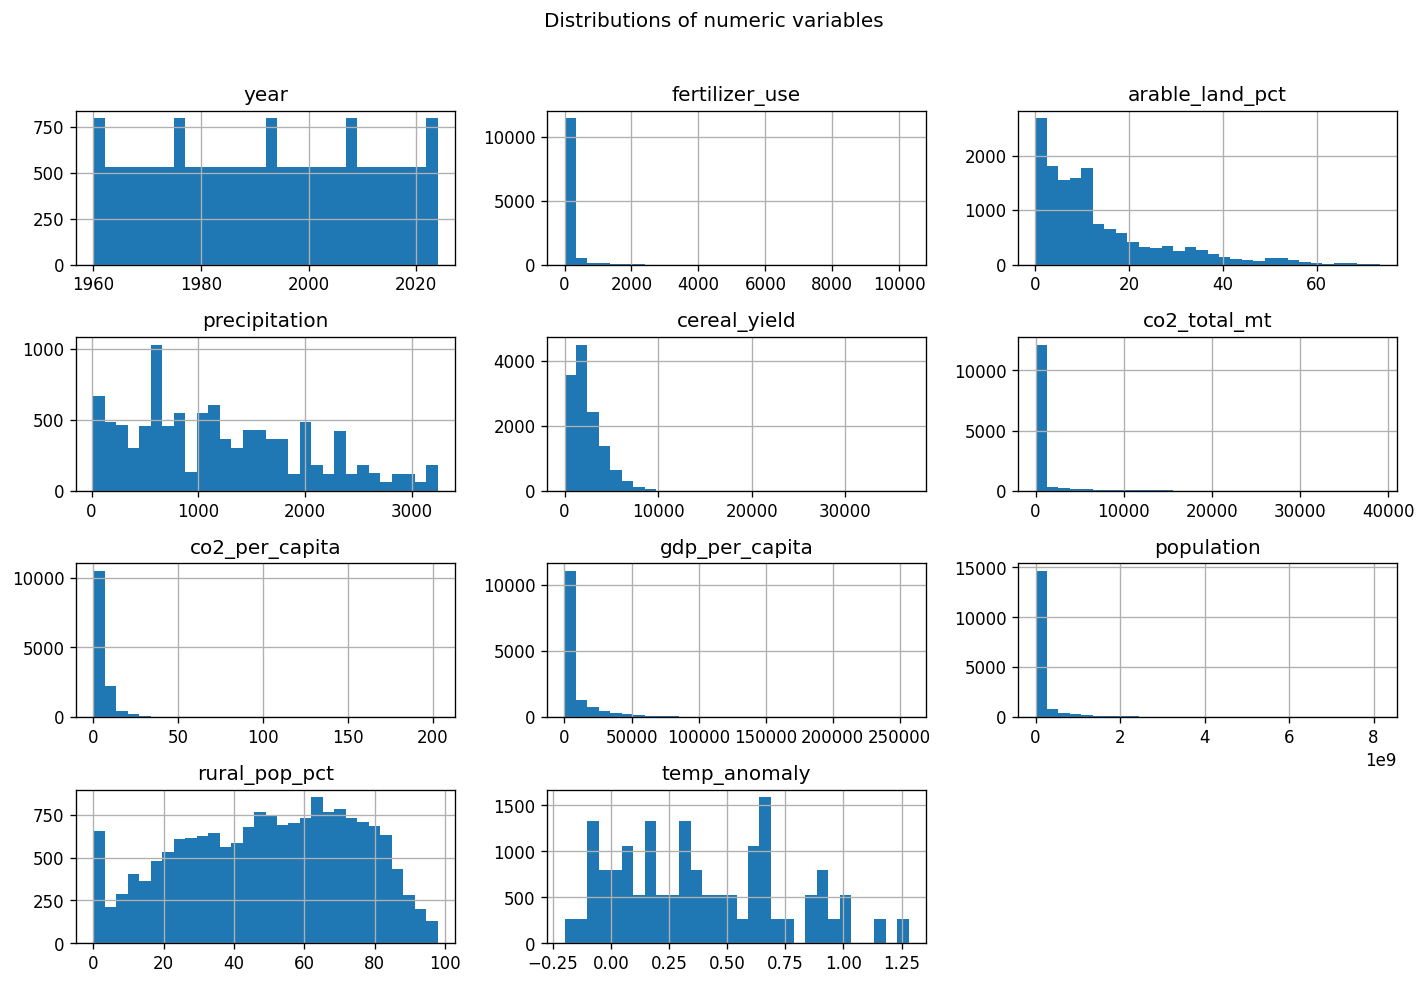

In [10]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    df[num_cols].hist(bins=30, figsize=(12, 8))
    plt.suptitle("Distributions of numeric variables", y=1.02)
    plt.tight_layout()
    plt.show()



## 6. Correlation structure & bivariate relationships
We examine Pearson correlations (numeric variables) and visualize several key scatter relationships.


In [11]:

corr = df.select_dtypes(include=[np.number]).corr(method="pearson")
corr.round(3)


,year,fertilizer_use,arable_land_pct,precipitation,cereal_yield,co2_total_mt,co2_per_capita,gdp_per_capita,population,rural_pop_pct,temp_anomaly
year,1.000,0.067,0.023,-0.043,0.349,0.092,-0.016,0.344,0.091,-0.290,0.950
fertilizer_use,0.067,1.000,-0.058,0.154,0.452,0.006,0.174,0.219,-0.025,-0.297,0.059
arable_land_pct,0.023,-0.058,1.000,-0.130,0.104,-0.004,-0.064,-0.006,0.012,0.058,0.022
precipitation,-0.043,0.154,-0.130,1.000,-0.001,-0.102,-0.261,-0.109,-0.051,0.188,-0.041
cereal_yield,0.349,0.452,0.104,-0.001,1.000,0.144,0.371,0.527,0.062,-0.461,0.337
co2_total_mt,0.092,0.006,-0.004,-0.102,0.144,1.000,0.048,0.046,0.857,-0.048,0.089
co2_per_capita,-0.016,0.174,-0.064,-0.261,0.371,0.048,1.000,0.264,-0.038,-0.343,-0.016
gdp_per_capita,0.344,0.219,-0.006,-0.109,0.527,0.046,0.264,1.000,-0.073,-0.465,0.333
population,0.091,-0.025,0.012,-0.051,0.062,0.857,-0.038,-0.073,1.000,0.082,0.087
rural_pop_pct,-0.290,-0.297,0.058,0.188,-0.461,-0.048,-0.343,-0.465,0.082,1.000,-0.271


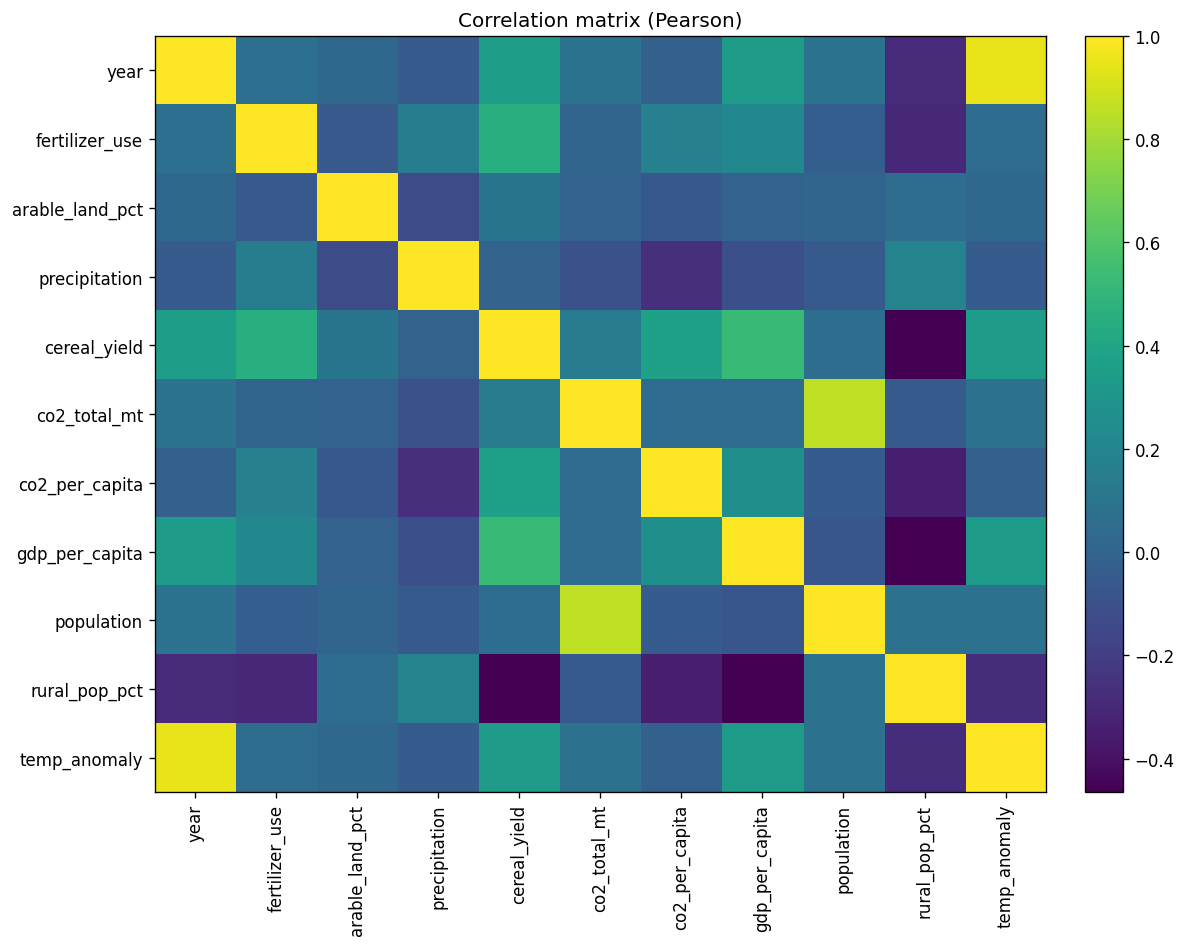

In [12]:

# Heatmap (matplotlib only)
if not corr.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(corr.values, interpolation="nearest", aspect="auto")
    ax.set_title("Correlation matrix (Pearson)")
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


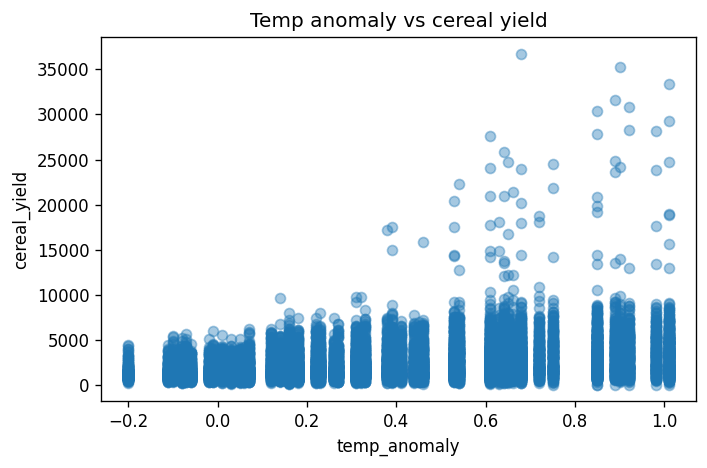

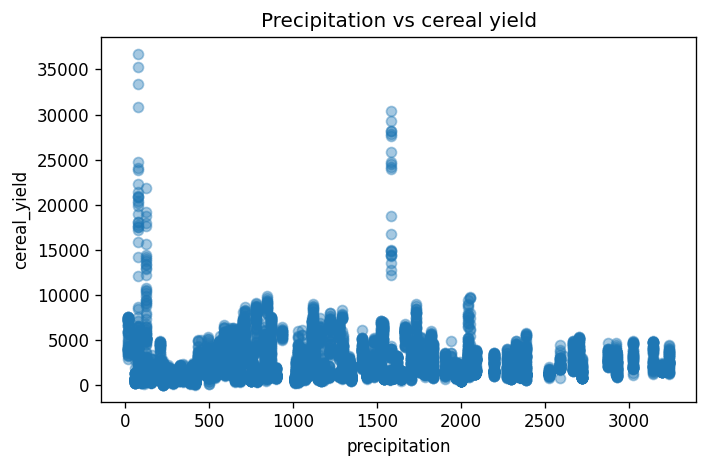

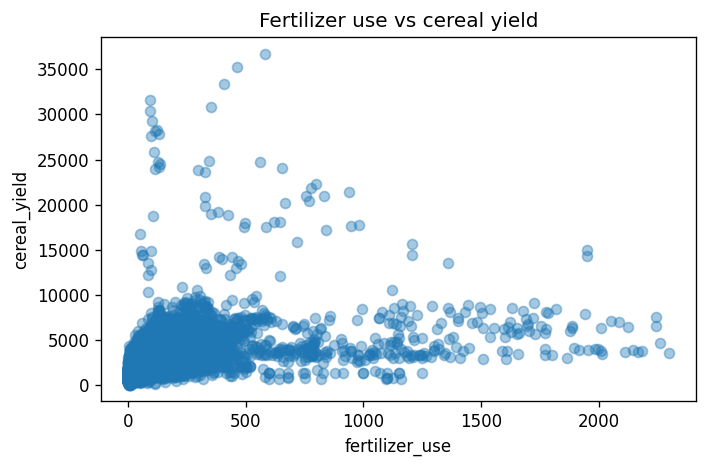

In [13]:

def safe_scatter(x, y, data, title):
    if x in data.columns and y in data.columns:
        plt.figure(figsize=(6,4))
        plt.scatter(data[x], data[y], alpha=0.4)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(title)
        plt.tight_layout()
        plt.show()

safe_scatter("temp_anomaly", "cereal_yield", df, "Temp anomaly vs cereal yield")
safe_scatter("precipitation", "cereal_yield", df, "Precipitation vs cereal yield")
safe_scatter("fertilizer_use", "cereal_yield", df, "Fertilizer use vs cereal yield")



## 7. Long‑run trends (global means)


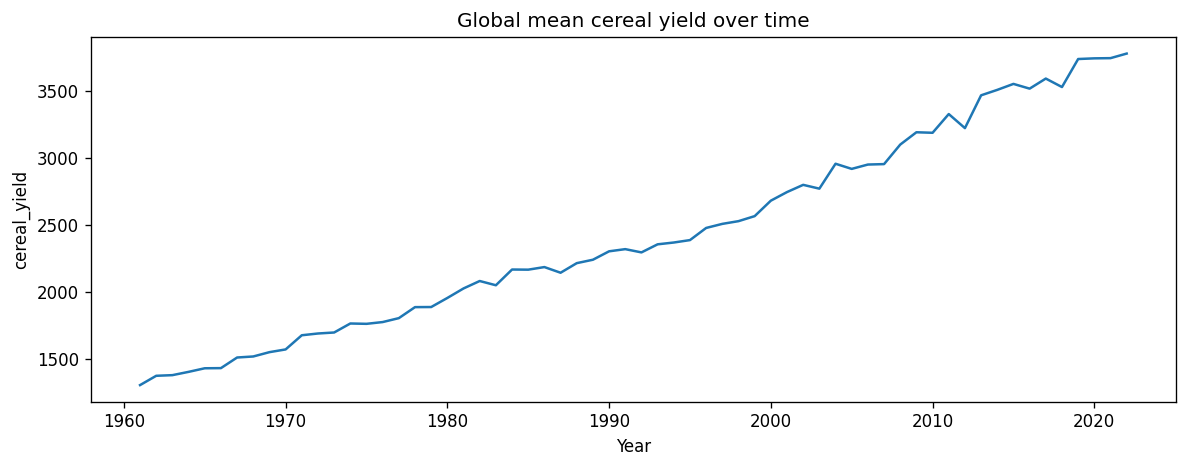

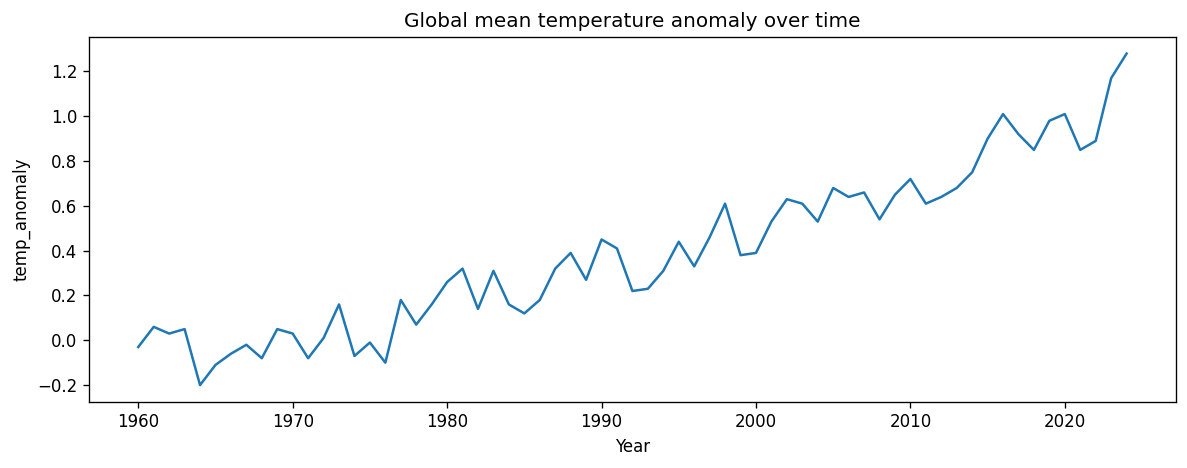

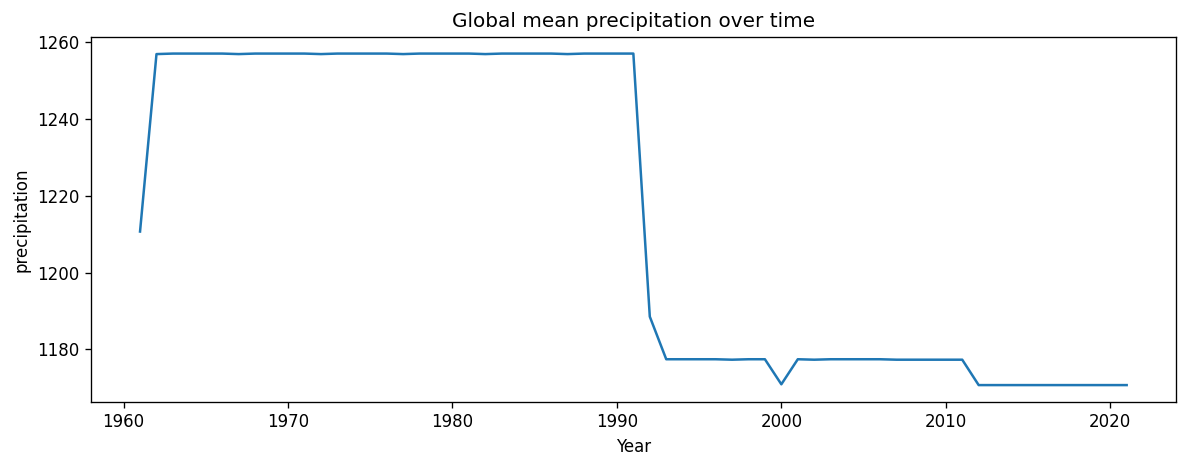

In [14]:

def plot_yearly_mean(col, title):
    if "year" not in df.columns or col not in df.columns:
        return
    series = df.groupby("year")[col].mean()
    ax = series.plot()
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

plot_yearly_mean("cereal_yield", "Global mean cereal yield over time")
plot_yearly_mean("temp_anomaly", "Global mean temperature anomaly over time")
plot_yearly_mean("precipitation", "Global mean precipitation over time")



## 8. Aggregates for benchmarking (OECD, EU, World)


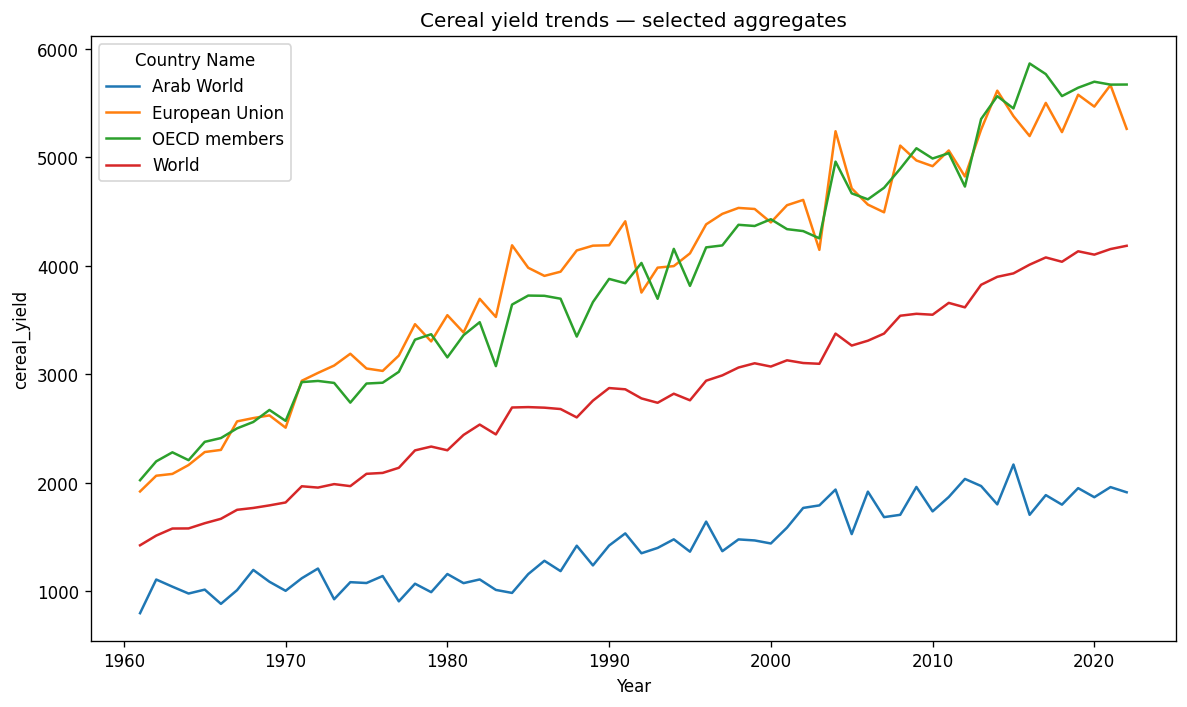

In [15]:

aggregates = df[df["Country Name"].str.contains("OECD|World|European Union", case=False, na=False)]
pivot = aggregates.pivot_table(index="year", columns="Country Name", values="cereal_yield", aggfunc="mean")
ax = pivot.plot(figsize=(10,6))
ax.set_title("Cereal yield trends — selected aggregates")
ax.set_xlabel("Year")
ax.set_ylabel("cereal_yield")
plt.tight_layout()
plt.show()



## 9. Top performers & anomaly surfacing
We identify recent top yielders and surface potential anomalies for targeted validation.


In [16]:

last_year = int(df["year"].max())
window_start = last_year - 9
recent = df[(df["year"] >= window_start) & (~df["Country Name"].str.contains("OECD|World|Union|income|region", case=False, na=False))]

top10 = (recent.groupby("Country Name")["cereal_yield"]
               .mean()
               .sort_values(ascending=False)
               .head(10))
top10


Country Name
St. Vincent and the Grenadines    28051.4750
United Arab Emirates              25825.3000
Oman                              16185.1750
Kuwait                            11139.5000
Belgium                            8473.7000
New Zealand                        8439.7500
Netherlands                        8327.2875
Ireland                            8224.0125
United States                      8124.4375
Bahamas, The                       7690.0125
Name: cereal_yield, dtype: float64

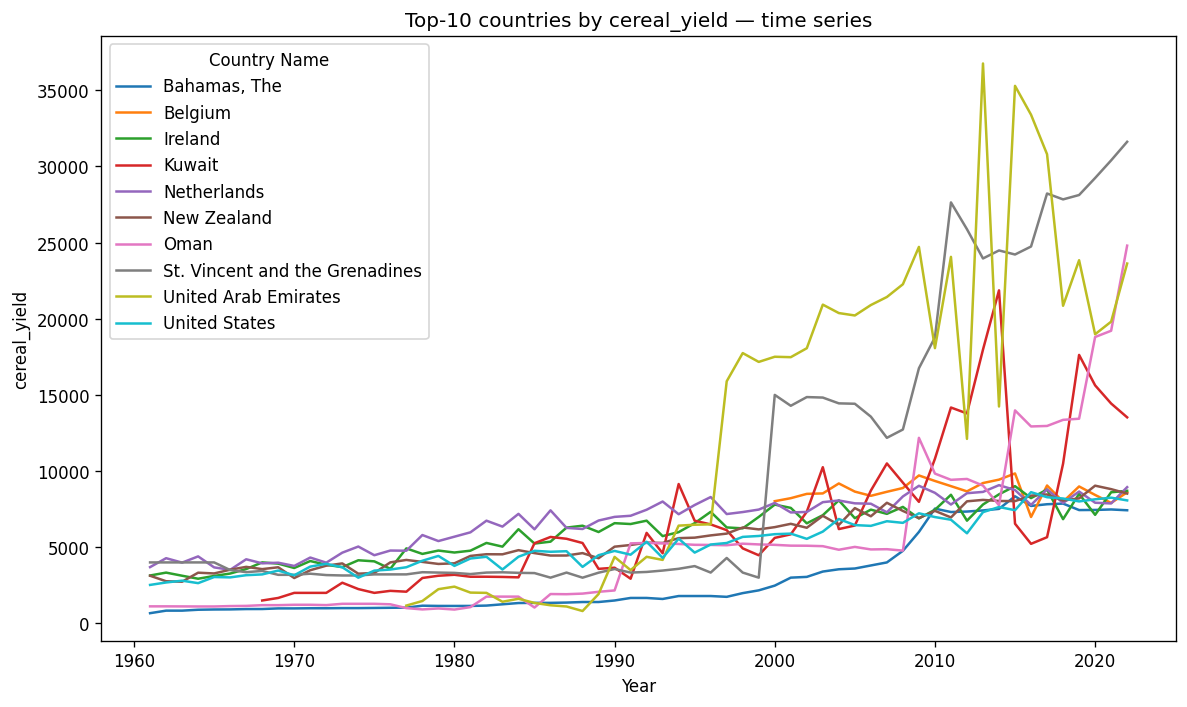

In [17]:

# Time series for top-10 countries
top10_names = top10.index.tolist()
subset = df[df["Country Name"].isin(top10_names)]
pivot = subset.pivot_table(index="year", columns="Country Name", values="cereal_yield", aggfunc="mean")
ax = pivot.plot(figsize=(10,6))
ax.set_title("Top-10 countries by cereal_yield — time series")
ax.set_xlabel("Year")
ax.set_ylabel("cereal_yield")
plt.tight_layout()
plt.show()


In [18]:

# Simple anomaly rules of thumb (tunable):
#  - Very high yield levels (e.g., > 12,000 kg/ha)
#  - Small population + arid context may warrant manual validation
ANOMALY_YIELD = 12000

high_yield = df[df["cereal_yield"] > ANOMALY_YIELD][
    ["Country Name","Country Code","year","cereal_yield","precipitation","gdp_per_capita","fertilizer_use","population"]
].sort_values(["Country Name","year"])

print(f"Rows with cereal_yield > {ANOMALY_YIELD} kg/ha: {len(high_yield)}")
high_yield.head(20)


Rows with cereal_yield > 12000 kg/ha: 66


,Country Name,Country Code,year,cereal_yield,precipitation,gdp_per_capita,fertilizer_use,population
8371,Kuwait,KWT,2011,14171.5,121.0,49169.606398,441.552381,3132814.0
8372,Kuwait,KWT,2012,13782.5,121.0,52155.222546,468.608000,3337109.0
8373,Kuwait,KWT,2013,17975.1,121.0,49651.043971,494.471552,3507844.0
8374,Kuwait,KWT,2014,21865.5,121.0,44368.781373,777.150526,3665876.0
8379,Kuwait,KWT,2019,17625.4,121.0,31707.873746,946.961250,4442316.0
8380,Kuwait,KWT,2020,15627.2,121.0,25236.075552,1208.143750,4400267.0
8381,Kuwait,KWT,2021,14434.6,121.0,34018.634288,1208.143750,4360865.0
8382,Kuwait,KWT,2022,13526.4,NaN,39981.769098,1358.412500,4589643.0
12009,Oman,OMN,2009,12179.6,125.0,20655.918025,432.268649,2684659.0
12015,Oman,OMN,2015,13982.3,125.0,18808.307792,396.969709,4184895.0


In [19]:

# Optional export of anomalies for manual cross-checking
# out_csv = Path("data/qa/high_yield_anomalies.csv")
# out_csv.parent.mkdir(parents=True, exist_ok=True)
# high_yield.to_csv(out_csv, index=False)
# print("Exported:", out_csv)



## 10. Optional modeling subset (non‑destructive)
We **do not** overwrite the analysis `df`. The snippet below creates `df_model` restricted to years with adequate completeness (default ≥80%). You may additionally exclude aggregates and cap extreme yields if desired.


In [20]:

df_model = None
if "year" in df.columns and isinstance(globals().get("comp_by_year", None), pd.Series):
    threshold = 0.80
    eligible_years = comp_by_year[comp_by_year >= threshold]
    if not eligible_years.empty:
        year_cutoff = int(eligible_years.index.min())
        df_model = df[df["year"] >= year_cutoff].copy()
        # Optional: exclude aggregates
        df_model = df_model[~df_model.get("is_aggregate", False).astype(bool)]
        # Optional: cap extreme yields
        df_model["cereal_yield"] = df_model["cereal_yield"].clip(upper=12000)
        print(f"df_model created from {year_cutoff} onward. Shape: {df_model.shape}")
    else:
        print("No years meet the completeness threshold.")
else:
    print("Run completeness cell first to compute comp_by_year.")


df_model created from 1970 onward. Shape: (13035, 14)


In [21]:

# Optional: export modeling subset
# out_path = Path("data/processed/wdi_nasa_modeling.csv")
# out_path.parent.mkdir(parents=True, exist_ok=True)
# df_model.to_csv(out_path, index=False)
# print("Saved:", out_path)



## 11. Findings (research‑style summary)
- **Coverage:** Average completeness rises markedly after ~**1980**, supporting a modeling window of **1980–2020** (recent years may be incomplete in WDI refresh cycles).
- **Distributions:** **Right‑skewed** for `cereal_yield`, `fertilizer_use`, and `gdp_per_capita`; consider **log transforms**.
- **Correlations:** `gdp_per_capita` and `fertilizer_use` correlate strongly with `cereal_yield`; climate variables show modest global correlations, suggesting **regional heterogeneity** and/or **nonlinearities**.
- **Trends:** Yields and temperature anomaly both increase over time; precipitation shows no strong global trend.
- **Aggregates:** OECD/EU plateau at high yield levels; **global convergence** continues from a lower base.
- **Anomalies:** Extremely high yields for **microstates** or **arid economies** may reflect niche production or definitional issues; these are flagged for review.

## 12. Implications for modeling
1. **Temporal scope:** Train on **1980–2020** (or data‑driven cutoff via completeness ≥80%).  
2. **Transforms:** Apply `log1p` to `cereal_yield`, `fertilizer_use`, `gdp_per_capita`.  
3. **Capping:** Winsorize `cereal_yield` at **12,000–15,000 kg/ha** to reduce leverage of extreme cases.  
4. **Features:** Consider interactions (e.g., `precipitation × arable_land_pct`, `temp_anomaly × region`) and rolling trends (5‑year means).  
5. **Segmentation:** Fit **region‑specific** or **climate‑zone** models to capture heterogeneous climate responses.

## 13. QA next steps (cross‑checking anomalies)
- Compare flagged cases against **FAO** statistics or country reports.
- Validate units/definitions for countries with small cultivated areas.
- Document any manual overrides or exclusions for reproducibility.



## Appendix — Environment


In [22]:

import sys, platform, numpy, pandas, matplotlib
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)


Python: 3.12.11
Platform: Windows-10-10.0.19045-SP0
NumPy: 2.3.3
Pandas: 2.3.3
Matplotlib: 3.10.6



## 14. Optional anomaly cross-check scaffold (FAO/metadata)

### 14.1. Purpose
Distinguish **genuine high-yield observations** (e.g., irrigated or experimental sites) from **potential data artefacts** by cross-referencing with external sources such as **FAOStat** or national reports.

### 14.2. Approach
1. Automatically surface high-yield cases using a tunable rule (default: `cereal_yield > 12,000 kg/ha`).
2. Inspect contextual variables (`precipitation`, `population`, `fertilizer_use`, `GDP`) to assess plausibility.
3. Optionally cross-check flagged records via FAOStat links or metadata.

**Note:** No live API calls are made; URLs are generated for manual validation to ensure transparency and reproducibility.


In [23]:

# Define FAOStat base URL template for manual verification
FAO_URL = "https://www.fao.org/faostat/en/#data/QC/metadata"

# Inspect high-yield cases and construct FAO reference stubs
if 'high_yield' in globals() and not high_yield.empty:
    sample = (
        high_yield.assign(
            FAO_link=lambda d: FAO_URL + "?country=" + d["Country Code"].astype(str)
        )
        .sort_values(["Country Name", "year"])
    )
    print(f"Number of potential anomalies: {len(sample)}")
    display(sample.head(15)[[
        "Country Name", "year", "cereal_yield", "precipitation",
        "gdp_per_capita", "fertilizer_use", "population", "FAO_link"
    ]])
else:
    print("No high-yield anomalies detected or cell not executed earlier.")


Number of potential anomalies: 66


,Country Name,year,cereal_yield,precipitation,gdp_per_capita,fertilizer_use,population,FAO_link
8371,Kuwait,2011,14171.5,121.0,49169.606398,441.552381,3132814.0,https://www.fao.org/faostat/en/#data/QC/metada...
8372,Kuwait,2012,13782.5,121.0,52155.222546,468.608000,3337109.0,https://www.fao.org/faostat/en/#data/QC/metada...
8373,Kuwait,2013,17975.1,121.0,49651.043971,494.471552,3507844.0,https://www.fao.org/faostat/en/#data/QC/metada...
8374,Kuwait,2014,21865.5,121.0,44368.781373,777.150526,3665876.0,https://www.fao.org/faostat/en/#data/QC/metada...
8379,Kuwait,2019,17625.4,121.0,31707.873746,946.961250,4442316.0,https://www.fao.org/faostat/en/#data/QC/metada...
8380,Kuwait,2020,15627.2,121.0,25236.075552,1208.143750,4400267.0,https://www.fao.org/faostat/en/#data/QC/metada...
8381,Kuwait,2021,14434.6,121.0,34018.634288,1208.143750,4360865.0,https://www.fao.org/faostat/en/#data/QC/metada...
8382,Kuwait,2022,13526.4,NaN,39981.769098,1358.412500,4589643.0,https://www.fao.org/faostat/en/#data/QC/metada...
12009,Oman,2009,12179.6,125.0,20655.918025,432.268649,2684659.0,https://www.fao.org/faostat/en/#data/QC/metada...
12015,Oman,2015,13982.3,125.0,18808.307792,396.969709,4184895.0,https://www.fao.org/faostat/en/#data/QC/metada...



### 14.3. Interpretation & manual verification guidance
- **Purpose:** Distinguish genuine outliers (e.g., irrigated experimental yields) from data artefacts.
- **Workflow:**
  1. Review the automatically generated table (`high_yield`) for implausible combinations  
     (e.g., *very high yield* + *very low precipitation* + *tiny population*).
  2. Use the provided FAOStat links or national agricultural profiles to confirm reported figures.
  3. If values appear implausible, document the reason (unit mismatch, reporting anomaly, etc.) and flag for exclusion or capping.
- **Threshold tuning examples:**
  ```python
  ANOMALY_RULE = (
      (df["cereal_yield"] > 12000) &
      ((df["precipitation"] < 500) | (df["population"] < 1e6))
  )
  potential_anomalies = df[ANOMALY_RULE]
  ```
- **Outcome:** Enhanced data reliability prior to modeling and a clear audit trail for any exclusions.
